In [1]:
import pandas as pd
import numpy as np
import shap
import time
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
import re
import pickle as pkl
import lightgbm as lgb


from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll.base import Apply

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence

#Creating a custom time series cross-validator
class CustomTimeSeriesCV(BaseCrossValidator):
    """Creates an iterator that contains the indices from each dataset based on the years given"""
    def __init__(self, years):
        self.years = years

    def split(self, X, y=None, groups=None):
        for train_years, test_years in self.years:
            train_indices = np.where(X['year'].isin(train_years))[0]
            test_indices = np.where(X['year'].isin(test_years))[0]
            yield train_indices, test_indices
        
    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.years) 
    
#Bootstraps X and y
def bootstrap(group, n=None):
    if n is None:
        n = len(group)
    return group.sample(n, replace=True)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
np.seterr(divide='ignore', invalid='ignore')

#Categorical features that need to be one-hot encoded    
one_hot_fts = ['office_type']

#Rating is the only ordinal feature
ordinal_fts = ['final_rating']

#Rating is the only ordinal feature
ordinal_fts = ['final_rating']
ordinal_fts_ranking = ['Safe R', 'Likely R', 'Leans R', 'Toss-up', 'Leans D', 'Likely D', 'Safe D']

#Cont features that should be pass-throughed (and later scaled)
cont_fts = [
    "open_seat", "incumbent_differential", "special", "absenteeexcusereq", "pollhours", "avgpollhours", "minpollhours",
    "regdeadlines", "voteridlaws", "novoterid", "noallmailvote", "noearlyvote", "nofelonreg",
    "nofelonsregafterincar", "nonstrictid", "nonstrictphoto", "nopollplacereg", "nopr", "nosamedayreg",
    "nostateholiday", "pr16", "pr17", "pr175", "pr60", "pr90", "strictid", "strictphoto", "covi_num",
    "prev_dem_gen_tp", "prev_gen_margin", "weighted_genpoll", "weighted_genpoll_lower",
    "weighted_genpoll_upper", "unweighted_genpoll", "mean_specials_differential", 
    "house_chamber_margin", "senate_chamber_margin", "previous_cci", "current_cci", "change_cci",
    "previous_gas", "current_gas", "change_gas", "previous_unemployment", "current_unemployment",
    "change_unemployment",  "receipts", "from_committee_transfers", "disbursements",
    "to_committee_transfers", "beginning_cash", "ending_cash", "candidate_contributions",
    "individual_contributions", "unconvinced_pct", "phone_unweighted", "online_unweighted", "num_polls",
    "unweighted_estimate", "unweighted_ci_lower", "unweighted_ci_upper", "weighted_estimate",
    "weighted_ci_lower", "weighted_ci_upper", "white_pct", "black_pct", "asian_pct", "hispanic_pct",
    "median_income", "impoverished_pct", "median_age", "renting_pct", "inflation", "isMidterm",
    "genballot_predicted_margin", "genballot_predicted_lower", "genballot_predicted_upper",
    "poll_fundamental_agree",  'receipts_DEM', 'receipts_REP', 'disbursements_DEM', 'disbursements_REP', 
    'average_genballot', 'genballot_individual_predicted_margin', 'genballot_campaign5_predicted_margin', 
    'genballot_campaign10_predicted_margin', 'genballot_campaign15_predicted_margin', 
    'average_genballot_predicted_margin', 'expert_rating_democrat', 'finance_fundamental_agree'
]

def optima_model(model, param_dict, data, **kwargs):
    """Performs hyperparameter optimization for a a given model, keeping track of loss. 
    ## Parameters:
    model: sklearnable model, like XGBoost or Linreg
    param_dict: dictionary of hyperparameters to optimize
    X: DataFrame with features
    y: Series with target variable"""

    train, _ = data.loc[data['year'] < 2022], data.loc[data['year'] == 2022]

    # Create fold structure so we can make a custom cross-validation for time-series
    folds = [
        (range(2002, 2010, 2), [2010, 2012]),
        (range(2002, 2014, 2), [2014, 2016]),
        (range(2002, 2018, 2), [2018, 2020])
    ]

    cv = CustomTimeSeriesCV(folds)
        
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(), one_hot_fts),
        ('ord', OrdinalEncoder(categories = [ordinal_fts_ranking], handle_unknown='use_encoded_value', 
                               unknown_value=np.nan), ordinal_fts),
        ('num', 'passthrough', cont_fts)])
    
    def objective(params):
        "Function that takes in hyperparameters and returns loss, that Hyperopt will minimize."        
        testing_loss = []
        accuracies = []
        for train_idx, test_idx in cv.split(train):
            bootstrapped_train = train.iloc[train_idx].groupby(['year', 'office_type']).apply(bootstrap)
            X_train = bootstrapped_train.drop(columns = ['margin'])
            y_train = bootstrapped_train['margin']
            X_test = train.iloc[test_idx].drop(columns = ['margin'])
            y_test = train.iloc[test_idx]['margin']
                   
            reg = model(**params)
            pipe = Pipeline(steps = [
                ('preprocessing', preprocessor), 
                ('model', reg)])
                                    
            """Goes through each fold and calculates loss."""
            pipe.fit(X_train, y_train)
            
            predictions = pipe.predict(X_test)
            testing_loss.append(mean_squared_error(y_test, predictions, squared=False))
            accuracies.append(accuracy_score(np.sign(y_test), np.sign(predictions)))
            
        return {'loss': np.mean(testing_loss), 'status': STATUS_OK}


    "Hyperopt uses the TPE algorithm to optimize hyperparameters. We use the no_progress_loss function to stop early if we don't see progress."
    best_params = fmin(fn=objective,
                    space=param_dict,
                    algo=tpe.suggest,
                    trials=Trials(),
                    early_stop_fn=no_progress_loss(10))
                    
    model = model(**best_params, **kwargs)
    pipe = Pipeline(steps = [
        ('preprocessing', preprocessor), 
        ('model', model)])
    
    #Training final model on data prior to and including 2022, so we get the full extent of the data!
    X, y = data.loc[data['year'] <= 2022, :].drop(columns = ['margin']), data.loc[data['year'] <= 2022, :]['margin']
    
    pipe.fit(X, y)
    
    return pipe

In [3]:
data = pd.read_csv("../cleaned_data/Engineered Dataset.csv")
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(), one_hot_fts),
        ('ord', OrdinalEncoder(categories = [ordinal_fts_ranking], handle_unknown='use_encoded_value', 
                               unknown_value=np.nan), ordinal_fts),
        ('num', 'passthrough', cont_fts)])

names_for_monotonicity = preprocessor.fit(data.drop(columns=['margin'])).get_feature_names_out()
before_processing_monotonic_columns = ['incumbent_differential', 'receipts', 'disbursements', 
                                       'genballot_predicted_margin', 'specials_predicted_margin', 'unweighted_estimate', 'unweighted_ci_lower',
                                       'unweighted_ci_upper','weighted_estimate', 'weighted_ci_lower', 'weighted_ci_upper',
                                       'phone_unweighted', 'online_unweighted', 'receipts_genballot_interaction',
                                       'disbursements_genballot_interaction', 'poll_fundamental_average']

monotonic_columns = ['num__' + name for name in before_processing_monotonic_columns] + ['ord__final_rating']
monotone_constraints = [1 if name in monotonic_columns else 0 for name in names_for_monotonicity]

# Define the search space for Hyperopt
param_dist_lgbm = {
    'boosting_type': 'dart',
    'num_leaves': hp.randint('num_leaves', 20, 70),  # Reduced the upper limit, 
    'n_estimators': hp.randint('n_estimators', 50, 200),  # Increased the range
    'learning_rate': hp.loguniform('learning_rate', -5, -2),  # Equivalent to about 0.0001 to 0.01
    'subsample_for_bin': hp.randint('subsample_for_bin', 20000, 200000),  # Narrowed the range
    'min_data_in_bin': hp.randint('min_data_in_bin', 1, 10), 
    'min_data_in_leaf': hp.randint('min_data_in_leaf', 1, 10),  # Reduced the upper limit
    'min_child_samples': hp.randint('min_child_samples', 20, 150),  # Increased the range for more regularization
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.5),  # Increased upper limit for L1 regularization
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.5),  # Increased upper limit for L2 regularization
    'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 0.8),  # Reduced the upper limit
    'subsample': hp.uniform('subsample', 0.5, 0.8),  # Reduced the upper limit for more randomness
    'max_depth': hp.randint('max_depth', 2, 10),  # Added max_depth for additional control
    'drop_rate': hp.uniform('drop_rate', 0.05, 0.5),  # Added drop_rate for dart
    'skip_drop': hp.uniform('skip_drop', 0.1, 0.9),  # Added skip_drop for dart
    "verbose": -1,  # Keep verbose to -1 to reduce log clutter,  
    'monotone_constraints': monotone_constraints, 
    'n_jobs': 8
}

num_trials = 10
for idx in range(num_trials):
    
    trained_lgbm = optima_model(lgb.LGBMRegressor, param_dist_lgbm, data,
                                boosting_type = 'dart', monotone_constraints = monotone_constraints, verbosity = -1, 
                                n_jobs = 8)
    print(trained_lgbm.named_steps['model'].get_params())
    
    file_path = f"../bootstrapped_models_testing/Model_{idx}.pkl"

    # Open a file to write in binary mode????        
    with open(file_path, 'wb') as file:
        pkl.dump(trained_lgbm, file)


  0%|          | 24/9223372036854775807 [03:06<19960366440573926:58:08,  7.79s/trial, best loss: 8.29199760499154] 
{'boosting_type': 'dart', 'class_weight': None, 'colsample_bytree': 0.7923653309626872, 'importance_type': 'split', 'learning_rate': 0.13080112759759152, 'max_depth': 8, 'min_child_samples': 119, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 154, 'n_jobs': 8, 'num_leaves': 62, 'objective': None, 'random_state': None, 'reg_alpha': 0.2376508807142858, 'reg_lambda': 1.356730343882979, 'subsample': 0.7614484692144594, 'subsample_for_bin': 187457, 'subsample_freq': 0, 'drop_rate': 0.4455668539679096, 'min_data_in_bin': 8, 'min_data_in_leaf': 8, 'skip_drop': 0.5528202167808689, 'monotone_constraints': [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [4]:
data = pd.read_csv("../cleaned_data/Engineered Dataset.csv")
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(), one_hot_fts),
        ('ord', OrdinalEncoder(categories = [ordinal_fts_ranking], handle_unknown='use_encoded_value', 
                               unknown_value=np.nan), ordinal_fts),
        ('num', 'passthrough', cont_fts)])

names_for_monotonicity = preprocessor.fit(data.drop(columns=['margin'])).get_feature_names_out()
print(names_for_monotonicity)

['cat__office_type_Governor' 'cat__office_type_House'
 'cat__office_type_President' 'cat__office_type_Senate'
 'ord__final_rating' 'num__open_seat' 'num__incumbent_differential'
 'num__special' 'num__absenteeexcusereq' 'num__pollhours'
 'num__avgpollhours' 'num__minpollhours' 'num__regdeadlines'
 'num__voteridlaws' 'num__novoterid' 'num__noallmailvote'
 'num__noearlyvote' 'num__nofelonreg' 'num__nofelonsregafterincar'
 'num__nonstrictid' 'num__nonstrictphoto' 'num__nopollplacereg'
 'num__nopr' 'num__nosamedayreg' 'num__nostateholiday' 'num__pr16'
 'num__pr17' 'num__pr175' 'num__pr60' 'num__pr90' 'num__strictid'
 'num__strictphoto' 'num__covi_num' 'num__prev_dem_gen_tp'
 'num__prev_gen_margin' 'num__weighted_genpoll'
 'num__weighted_genpoll_lower' 'num__weighted_genpoll_upper'
 'num__unweighted_genpoll' 'num__mean_specials_differential'
 'num__house_chamber_margin' 'num__senate_chamber_margin'
 'num__previous_cci' 'num__current_cci' 'num__change_cci'
 'num__previous_gas' 'num__current_g

(array([ 1.,  3., 24., 81., 17.,  6.,  3.,  9.,  5.,  1.]),
 array([ 85. , 124.3, 163.6, 202.9, 242.2, 281.5, 320.8, 360.1, 399.4,
        438.7, 478. ]),
 <BarContainer object of 10 artists>)

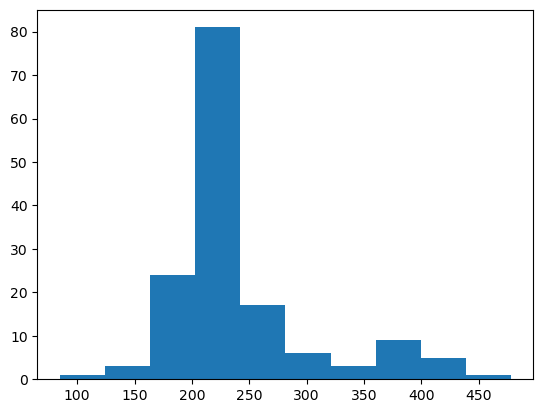

In [13]:
data = np.array([287, 238, 245, 226, 190, 276, 208, 226, 226, 226, 208, 226, 243, 226, 226, 182, 241, 226,
                 276, 226, 226, 226, 208, 226, 226, 226, 276, 226, 226, 226, 182, 218, 219, 208, 226, 226,
                 268, 226, 203, 226, 208, 208, 282, 208, 208, 172, 208, 226, 186, 218, 226, 208, 226, 226,
                 241, 232, 518, 303, 226, 208, 226, 226, 287, 188, 235, 222, 193, 190, 268, 208, 226, 226,
                 276, 461, 268, 226, 218, 266, 218, 226, 256, 218, 195, 201, 226, 226, 222, 203, 208, 226,
                 226, 208, 226, 272, 226, 208, 221, 195, 226, 241, 226, 382, 226, 459, 146, 182, 226, 232,
                 287, 226, 226, 208, 226, 218, 352, 226, 226, 266, 226, 226, 198, 326, 208, 226, 222, 190,
                 232, 226, 208, 226, 226, 226, 232, 226, 200, 226, 226, 226, 226, 459, 226, 226, 208, 266,
                 222, 226, 333, 209, 226, 208])
data_2 = np.array([208, 226, 222, 226, 226, 295, 226, 276, 276, 226, 216, 208, 226, 226, 172, 170, 226, 208,
                   364, 226, 266, 226, 208, 378, 226, 190, 203, 226, 226, 208, 226, 198, 276, 226, 226, 276,
                   190, 208, 226, 208, 222, 182, 383, 182, 230, 226, 226, 222, 226, 208, 253, 370, 258, 139,
                   274, 226, 411, 287, 423, 313, 276, 226, 248, 218, 180, 424, 226, 276, 158, 319, 180, 217,
                   218, 226, 226, 398, 226, 166, 226, 226, 226, 203, 226, 85, 208, 188, 213, 356, 221, 180,
                   195, 195, 208, 180, 208, 217, 276, 222, 334, 208, 226, 390, 305, 226, 208, 226, 424, 221,
                   251, 190, 208, 182, 226, 364, 172, 420, 195, 226, 276, 226, 226, 478, 226, 200, 168, 259,
                   226, 364, 226, 230, 263, 388, 226, 226, 172, 237, 226, 226, 166, 218, 155, 292, 226, 226,
                   226, 266, 226, 241, 200, 331])
import matplotlib.pyplot as plt
plt.hist(data_2)